# Exercises

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 

In [2]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 50 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [3]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [4]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

In [5]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|███████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


In [6]:
spike_positions = [np.interp(s, t, x) for s in spikes]

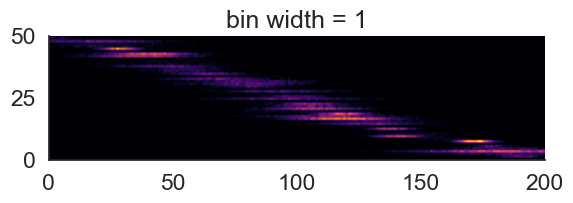

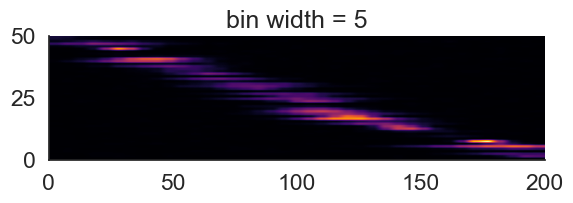

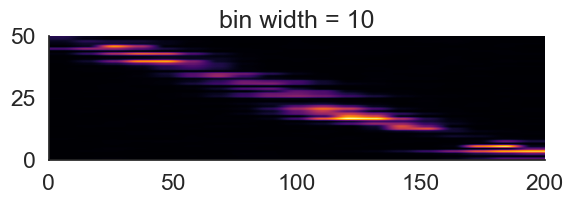

In [7]:
bin_widths = [1.0, 5.0, 10.0]
index = 0
for a in bin_widths:
    fig = plt.figure(index)
    space_bins = np.arange(0., 200., a)
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)

    plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title('bin width = %i' %a)
    plt.show()

So we see that for bigger bin widths the plot is more smooth

B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


In [8]:
def tmp_func(noise):
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    
    noise_firing_rate = noise # the baseline noise firing rate
    
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    
    spike_positions = [np.interp(s, t, x) for s in spikes]
    
    return spike_positions

100%|███████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


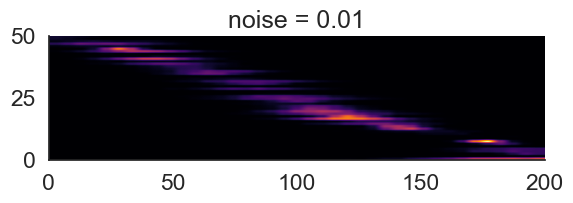

100%|███████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


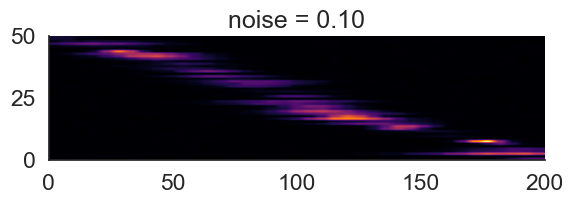

100%|███████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


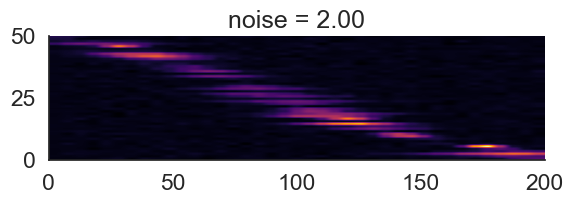

In [9]:
noises = [0.005, 0.1, 2]

index = 0
for noise in noises:
    spike_positions = tmp_func(noise)
    fig = plt.figure(index)
    space_bins = np.arange(0., 200., 5.)
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)

    plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title('noise = %.2f' %noise)
    plt.show()
    
    index += 1

We see that the background noise is a bit more present, but otherwise I don't see that much difference.

C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

In [10]:
#?scipy.stats.gaussian_kde

100%|███████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


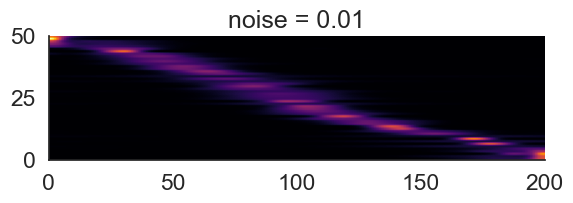

100%|███████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


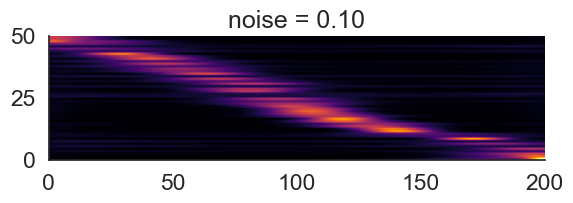

100%|███████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


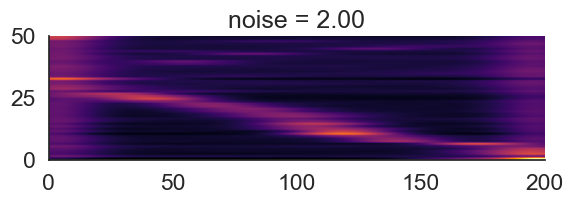

In [11]:
noises = [0.005, 0.1, 2]

index = 0
for noise in noises:
    spike_positions = tmp_func(noise)
    fig = plt.figure(index)
    space_bins = np.arange(0., 200., 1.)
    
    gaussians = []
    for s in spike_positions:
        kde = scipy.stats.gaussian_kde(s.T)
        gaussians.append(kde(space_bins))
    gaussians = np.array(gaussians)    
    
    peak_locations = gaussians.argmax(axis=1)
    ix = np.argsort(peak_locations)

    plt.imshow(gaussians[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title('noise = %.2f' %noise)
    plt.show()
    
    index += 1

We see the noise a lot more clearly here

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 

In [12]:
cpfs = []
for s in spike_positions:
    Nspikes = len(s)
    summation = np.sum(s)
    cpfs.append((1/Nspikes)*summation)

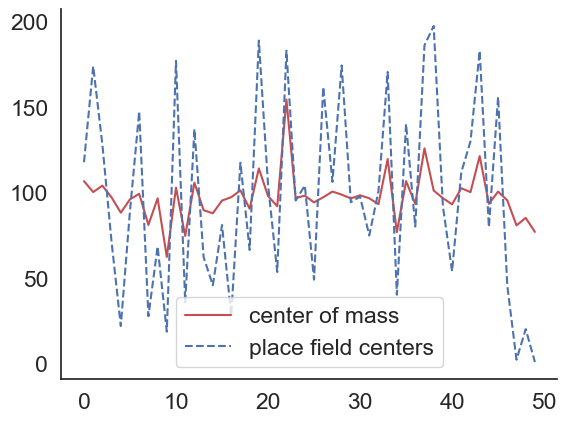

In [13]:
cpfs = np.reshape(np.array(cpfs), 50)

plt.plot(cpfs, 'r', label='center of mass')
plt.plot(pf_centers, 'b--', label='place field centers')
plt.legend()
plt.show()

We see that the shape of the graph of the center of mass somewhat follows the shape of the real place field centers, but that it has values closer to the middle of the length than the real pfs do.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

The formula:

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x) + \epsilon}{\lambda} p_{occ}(x) $$ 

Where $\epsilon$ is a very small number (e.g. $10^{-15}$) This small number avoids infinities (and NaNs) when $\lambda(x) = 0$.

where $\lambda(x)$ is the firing rate map (as defined above, with some binning precision) $\lambda$ is the average firing rate of the neuron, and $p_{occ}(x)$ is the occupancy as defined above. Information from this formula is expressed in bits per second.

In [14]:
noise = 0.1
spike_positions = tmp_func(noise)
space_bins = np.arange(0., 200., 5)
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.vstack(spikes_hist).astype(np.float64)
occupancy = np.histogram(x, space_bins)[0] /  fps
firing_rate_maps = spikes_hist / occupancy 

eps = 10**(-15)

100%|███████████████████████████████████████████| 50/50 [00:50<00:00,  1.02s/it]


In [15]:
mut_inf = []
for i in range(0, n_cells):
    frm = firing_rate_maps[i]
    avg_fr = pf_rate[i]
    arr = frm*np.log2( (frm+eps)*occupancy/avg_fr )
    mut_inf.append(np.sum(arr))

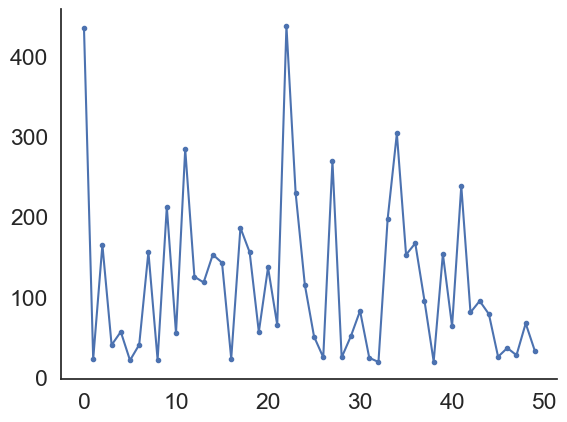

In [16]:
plt.plot(mut_inf, '.-')
plt.show()

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

In [17]:
def mut_inf_func1(frm, avg_fr, occ):
    eps = 10**(-15)
    arr = frm*np.log2( (frm+eps)*occ/avg_fr )
    mut_inf_bits_per_sec = np.sum(arr)
    return mut_inf_bits_per_sec
    
def mut_inf_func2(mut_inf_bpsec, avg_fr):
    mut_inf_bits_per_spike = mut_inf_bpsec/avg_fr
    return mut_inf_bits_per_spike

def frm_occ_func(space_bins, spike_pos, fps=30):
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_pos]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    return firing_rate_maps, occupancy

def spike_pos_func(noise, fps = 30):
    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps
    
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))

    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    
    spike_positions = [np.interp(s, t, x) for s in spikes]
    
    return spike_positions

In [18]:
# the main function

def main_func(average_firing_rate = 5, pf_size_avg = 10, noise_firing_rate = 0.1):
    track_length = 200. # the length of our linear track (eg in centimeter)
    n_cells = 50 # how many cells we are recording
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(pf_size_avg, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution
    bin_width = 5.
    space_bins = np.arange(0., 200., bin_width)
    
    spike_positions = spike_pos_func(noise_firing_rate)

    firing_rate_maps, occupancy = frm_occ_func(space_bins, spike_positions)

    mut_inf_bits_per_sec = [] 
    mut_inf_bits_per_spike = []
    for frm in firing_rate_maps:
        mut_inf_bpsec = mut_inf_func1(frm, average_firing_rate, occupancy)
        mut_inf_bits_per_sec.append(mut_inf_bpsec)
        mut_inf_bits_per_spike.append(mut_inf_func2(mut_inf_bpsec, average_firing_rate))

    return mut_inf_bits_per_sec, mut_inf_bits_per_spike


### Varying peak firing rate

In [19]:
pfrs = [1,3,5,7,9,11]

m1_lst = []
m2_lst = []
for pfr in pfrs:
    m1, m2 = main_func(average_firing_rate = pfr, pf_size_avg = 10, noise_firing_rate = 0.1)
    m1_lst.append(m1)
    m2_lst.append(m2)

100%|███████████████████████████████████████████| 50/50 [00:36<00:00,  1.35it/s]


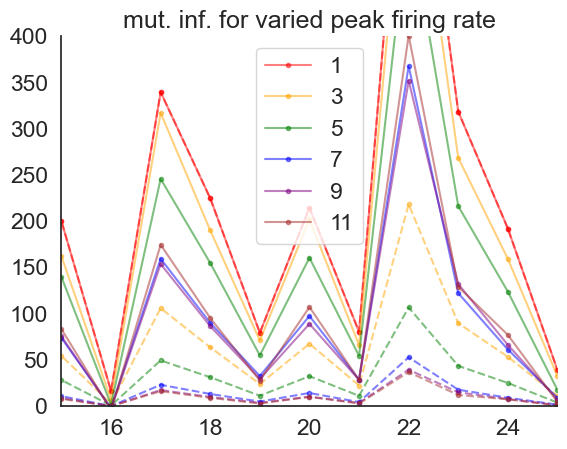

In [20]:
colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown']

for ind in range(0, len(pfrs)):
    m1 = m1_lst[ind]
    m2 = m2_lst[ind]
    c = colors[ind]
    plt.plot(m1, '.-', alpha = 0.5, color = c, label='%d'%pfrs[ind])
    plt.plot(m2, '.--', alpha = 0.5, color = c)
    
    ind +=1
plt.title('mut. inf. for varied peak firing rate')
plt.xlim((15,25))
plt.ylim((0,400))
plt.legend()
plt.show()

### Varying place cell size

In [21]:
pcss = [2,6,10,14,18,22]

m1_lst = []
m2_lst = []
for pcs in pcss:
    m1, m2 = main_func(pf_size_avg = pcs)
    m1_lst.append(m1)
    m2_lst.append(m2)

100%|███████████████████████████████████████████| 50/50 [00:37<00:00,  1.32it/s]


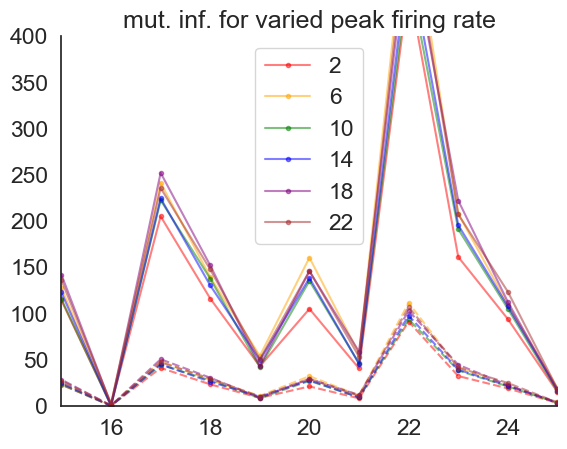

In [22]:
for ind in range(0, len(pcss)):
    m1 = m1_lst[ind]
    m2 = m2_lst[ind]
    c = colors[ind]
    plt.plot(m1, '.-', alpha = 0.5, color = c, label='%d'%pcss[ind])
    plt.plot(m2, '.--', alpha = 0.5, color = c)
    
    ind +=1
plt.title('mut. inf. for varied peak firing rate')
plt.xlim((15,25))
plt.ylim((0,400))
plt.legend()
plt.show()

### Varying baseline noise

In [23]:
noises = [0.02, 0.06, 0.1, 0.14, 0.18,0.22]

m1_lst = []
m2_lst = []
for noise in noises:
    m1, m2 = main_func(noise_firing_rate = noise)
    m1_lst.append(m1)
    m2_lst.append(m2)

100%|███████████████████████████████████████████| 50/50 [00:35<00:00,  1.40it/s]


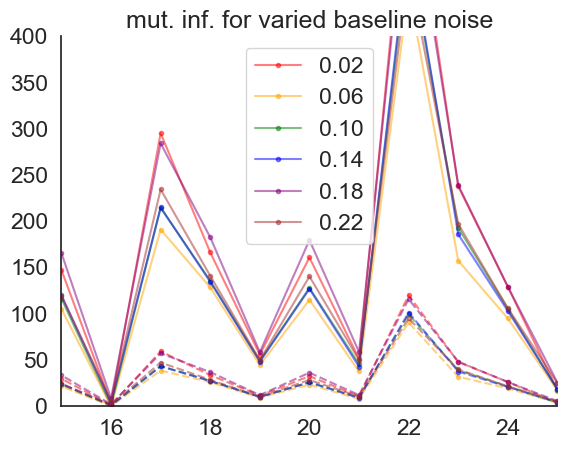

In [25]:
for ind in range(0, len(noises)):
    m1 = m1_lst[ind]
    m2 = m2_lst[ind]
    c = colors[ind]
    plt.plot(m1, '.-', alpha = 0.5, color = c, label='%.2f'%noises[ind])
    plt.plot(m2, '.--', alpha = 0.5, color = c)
    
    ind +=1
plt.title('mut. inf. for varied baseline noise')
plt.xlim((15,25))
plt.ylim((0,400))
plt.legend()
plt.show()

For peak firing rate we see a clear correlation. The higher the pfr, the lower the mut. inf. For the others I don't really see a clear correlation between higher values and the value of the mut. inf..

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.


In [26]:
#import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [27]:
pos_animal = data['x']
t = data['t']
spikes = data['spikes']

A - Visualiaze the position as a function of time. Plot the spike of a selected cell in space.

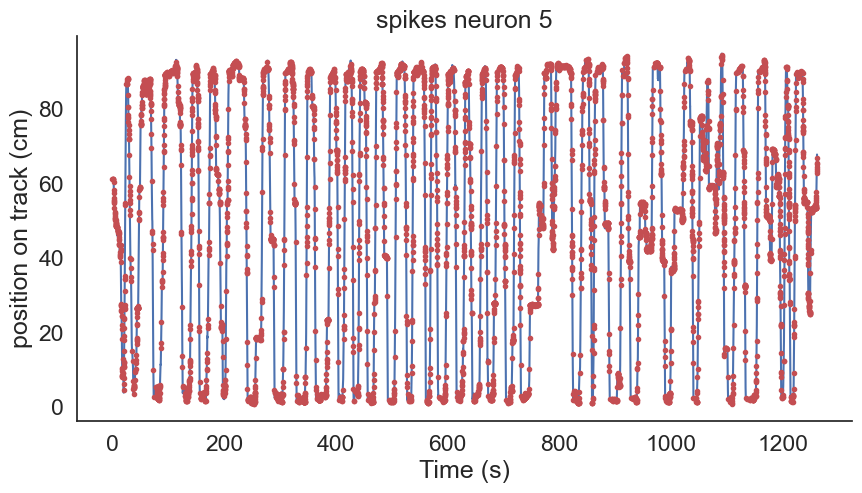

In [28]:
plt.figure(figsize=(10,5))
plt.plot(t, pos_animal)
plt.plot(spikes[5], np.interp(spikes[5], t, pos_animal), 'r.')
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')
plt.title('spikes neuron 5')
plt.show()

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.


In [29]:
spike_positions = [np.interp(s, t, pos_animal) for s in spikes]

In [30]:
def frm_occ_func(space_bins, spike_pos, fps):
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_pos]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    return firing_rate_maps, occupancy

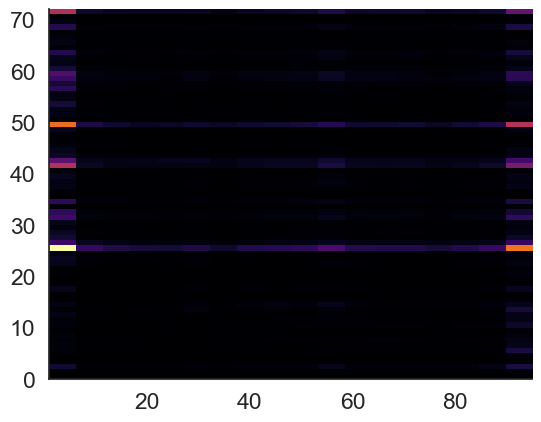

In [31]:
xmin = np.min(pos_animal)
xmax = np.max(pos_animal)
n_cells = len(spikes)

space_bins = np.arange(xmin, xmax, 5.)
fps = len(t)/np.max(t)

frms, occ = frm_occ_func(space_bins, spike_positions, fps)

peak_locations = frms.argmax(axis=1)
ix = np.argsort(peak_locations)

plt.imshow(frms[ix,:], cmap='inferno', extent = [xmin, xmax, 0, n_cells])
plt.show()

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [32]:
def mut_inf_func1(frm, avg_fr, occ):
    eps = 10**(-15)
    arr = frm*np.log2( (frm+eps)*occ/avg_fr )
    mut_inf_bits_per_sec = np.sum(arr)
    return mut_inf_bits_per_sec
    
def mut_inf_func2(mut_inf_bpsec, avg_fr):
    mut_inf_bits_per_spike = mut_inf_bpsec/avg_fr
    return mut_inf_bits_per_spike

In [33]:
mean_frs = []
for spikes_neuron in spikes:
    mean_frs.append(np.mean(spikes_neuron))

average_firing_rate = np.mean(mean_frs)

mut_inf_bits_per_sec = [] 
mut_inf_bits_per_spike = []
for frm in frms:
    mut_inf_bpsec = mut_inf_func1(frm, average_firing_rate, occ)
    mut_inf_bits_per_sec.append(mut_inf_bpsec)
    mut_inf_bits_per_spike.append(mut_inf_func2(mut_inf_bpsec, average_firing_rate))

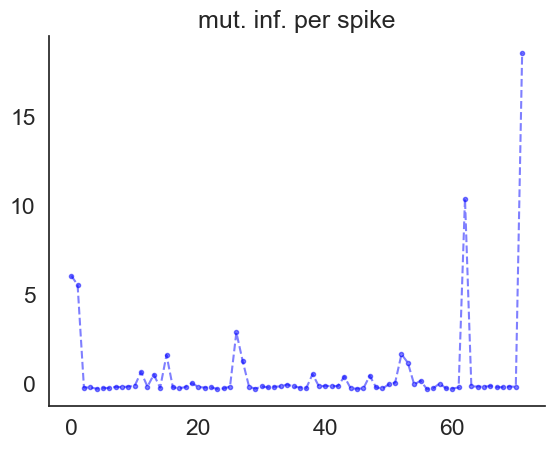

In [34]:
plt.plot(mut_inf_bits_per_spike, '.--', alpha = 0.5, color = 'blue')
plt.title('mut. inf. per spike')
plt.show()

In [35]:
m1 = np.array(mut_inf_bits_per_spike)
ix = np.argsort(m1)

neurons [56 23 45  4 29]


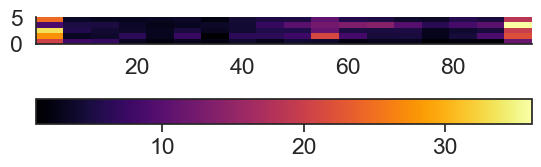

In [36]:
print('neurons', ix[0:5])
plt.figure()
im = plt.imshow(frms[ix[0:5],:], cmap='inferno', extent = [xmin, xmax, 0, 5])
plt.colorbar(im,location="bottom")
plt.show()

neurons [26  1  0 62 71]


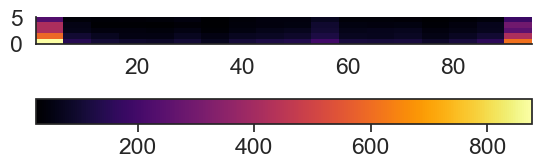

In [37]:
print('neurons', ix[-5:])
#plt.figure(figsize=(16,40))
plt.imshow(frms[ix[-5:],:], cmap='inferno', extent = [xmin, xmax, 0, 5])
plt.colorbar(location="bottom")
plt.show()

So the neurons with more information fire a lot more